In [71]:
import pandas as pd
import requests
import scipy.io
import io

def get_data_zenodo(url: str, filename: str, key: str) -> pd.DataFrame:
    """
    Get data from Zenodo and save it as a csv file.
    """
    response = requests.get(url)
    
    if response.status_code == 200:
        content_bytes = io.BytesIO(response.content)
        data = scipy.io.loadmat(content_bytes)
        
        try:
            df = pd.DataFrame(data[key].T)
            return df
        except ValueError:
            m = data[key]
            con_list = [[element for element in upperElement] for upperElement in m]
            allEnzymes = con_list[0][0][4][0][0]
            allEnzymes = [i[0][0] for i in allEnzymes]
            
            s = con_list[0][0][1][0][0]
            mcc = pd.DataFrame(s.reshape(200000,86))
            mcc.columns = allEnzymes
            return mcc
    else:
        print("Failed to download the file.")

# Data
url = "https://zenodo.org/records/10726643/files/training_set_ref.mat"
filename = "training_set_ref.mat"

df = get_data_zenodo(url, filename, 'training_set')

# Labels
url = "https://zenodo.org/records/10726643/files/class_vector_train_ref.mat"
filename = "class_vector_train_ref.mat"

df_labels = get_data_zenodo(url, filename, 'class_vector_train')

# Parameter names
url = "https://zenodo.org/records/10726643/files/paremeterNames.mat"
filename = "paremeterNames.mat"
 
names = get_data_zenodo(url, filename, 'parameterNames')

# MCC data
url = "https://zenodo.org/records/10726643/files/ccXTR_ref.mat"
filename = "ccXTR_ref.mat"

cc = get_data_zenodo(url, filename, 'commonEnzAct')

# Build dataset
names = [_[0] for _ in names.iloc[0].values]
labels = [_[0] for _ in df_labels.iloc[0].values]
df.columns = names
df['stability'] = labels
df['stability'] = df['stability'].map({'s': 1, 'ns': 0}).astype(int)

In [3]:
df = pd.read_csv('/home/WUR/g0012069/ml2rules/epfl_data.csv')
df['Stability'] = df['Stability'].map({'s': 1, 'ns': 0}).astype(float)
print(df.shape)

# Sample N rows for computational efficiency
df = df.sample(10000)
print(df.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../ml2rules/epfl_data.csv'

In [65]:
dfcolumns = df.columns
data = df.values

d = data.shape[1]

mu_ml = np.mean(data, axis=0)
data_cov = np.cov(data, rowvar=False)

In [66]:
q = int(df.shape[1] / 2)
# Variance
lambdas, eigenvecs = np.linalg.eig(data_cov)
idx = lambdas.argsort()[::-1]
lambdas = lambdas[idx]
eigenvecs = - eigenvecs[:,idx]

var_ml = (1.0 / (d-q)) * sum([lambdas[j] for j in range(q,d)])


# Weight matrix
uq = eigenvecs[:,:q]


lambdaq = np.diag(lambdas[:q])

print(uq.shape)
print(lambdaq.shape)
weight_ml = uq @ np.sqrt(lambdaq - var_ml * np.eye(q))
print(weight_ml.shape)

(259, 129)
(129, 129)
(259, 129)


In [67]:
def sample_hidden_given_visible(
    weight_ml : np.array,
    mu_ml : np.array,
    var_ml : float,
    visible_samples : np.array
    ) -> np.array:

    q = weight_ml.shape[1]
    m = np.transpose(weight_ml) @ weight_ml + var_ml * np.eye(q)

    cov = var_ml * np.linalg.inv(m) @ np.eye(q)
    act_hidden = []
    for data_visible in visible_samples:
        mean = np.linalg.inv(m) @ np.transpose(weight_ml) @ (data_visible - mu_ml)
        sample = np.random.multivariate_normal(mean.real, cov.real, size=1)
        act_hidden.append(sample[0])

    return np.array(act_hidden)

def sample_visible_given_hidden(
    weight_ml : np.array,
    mu_ml : np.array,
    var_ml : float,
    hidden_samples : np.array
    ) -> np.array:

    d = weight_ml.shape[0]

    act_visible = []
    for data_hidden in hidden_samples:
        mean = weight_ml @ data_hidden + mu_ml
        cov = var_ml * np.eye(d)
        sample = np.random.multivariate_normal(mean.real,cov.real,size=1)
        act_visible.append(sample[0])

    return np.array(act_visible)

In [68]:
act_hidden = sample_hidden_given_visible(
    weight_ml=weight_ml,
    mu_ml=mu_ml,
    var_ml=var_ml,
    visible_samples=data
    )

mean_hidden = np.full(q,0)
cov_hidden = np.eye(q)

no_samples = len(data)
samples_hidden = np.random.multivariate_normal(mean_hidden,cov_hidden,size=no_samples)

In [69]:
generated_samples = sample_visible_given_hidden(
    weight_ml=weight_ml,
    mu_ml=mu_ml,
    var_ml=var_ml,
    hidden_samples=samples_hidden
    )
generated_samples_df = pd.DataFrame(generated_samples, columns=dfcolumns)

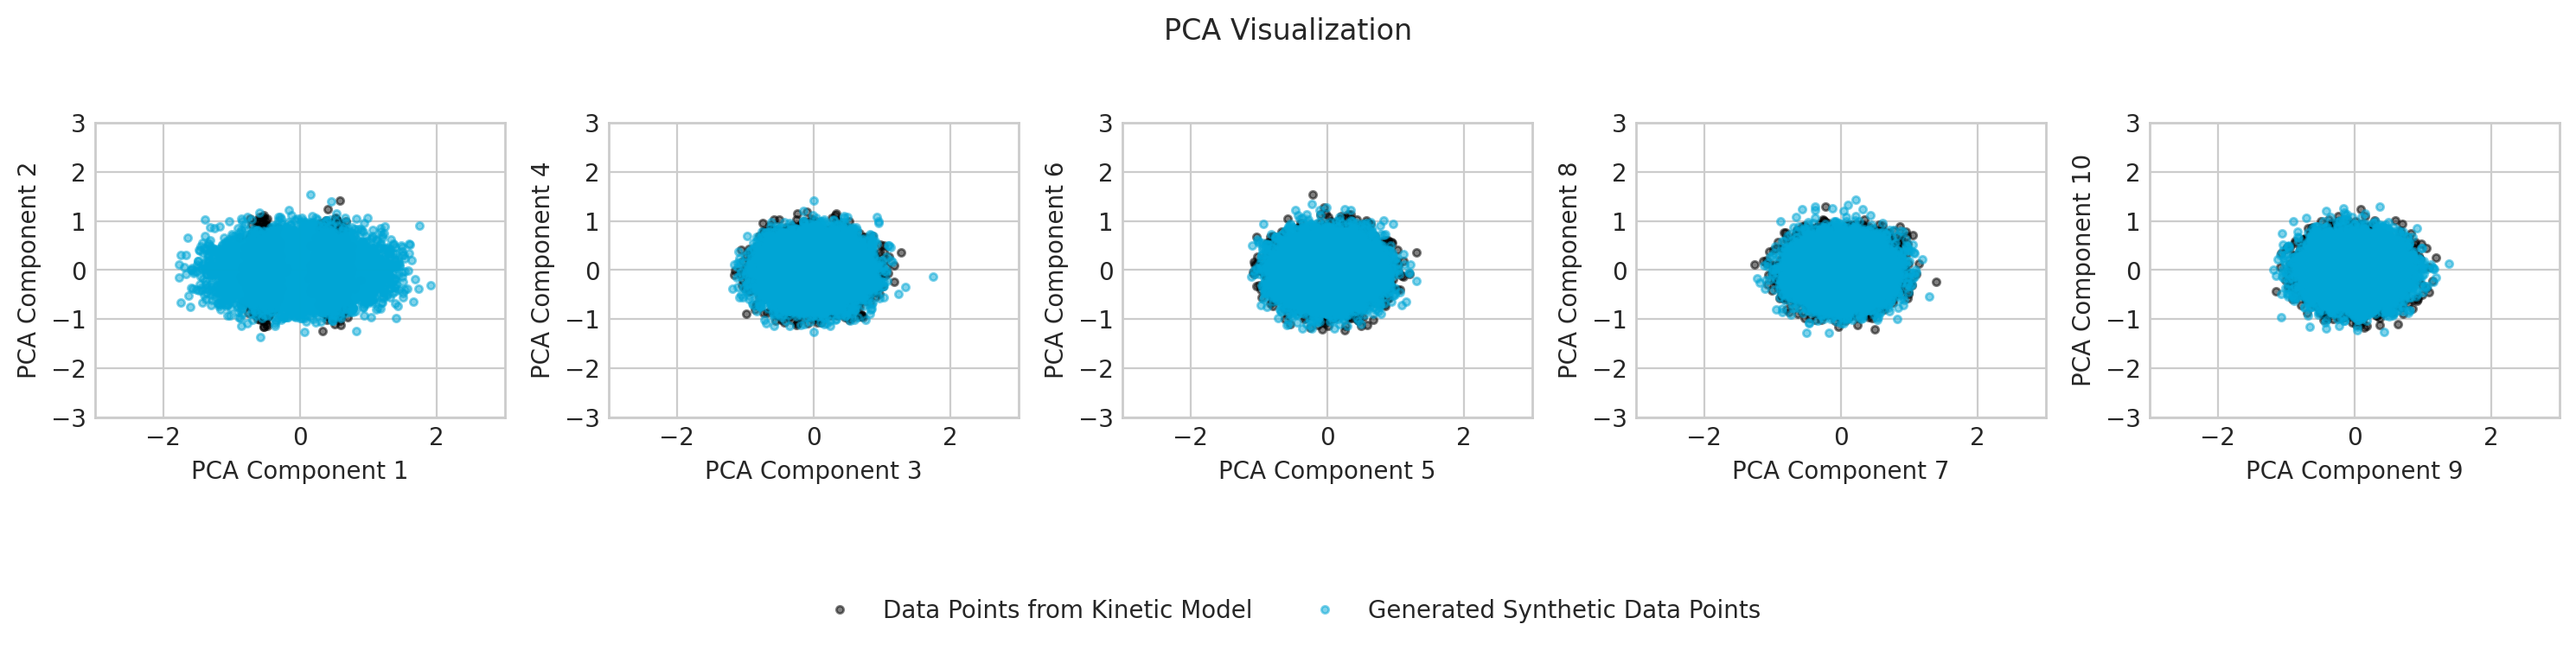

In [70]:
pca_real = PCA(n_components=10, random_state=42)
real_result = pca_real.fit_transform(data)
pca_synthetic = PCA(n_components=10, random_state=42)
synthetic_result = pca_synthetic.fit_transform(generated_samples)

fig, axes = plt.subplots(ncols=5, figsize=(15, 3))
for j, ax in enumerate(axes):
    index = 2 * j
    index2 = index + 1
    ax.plot(real_result[:, index], real_result[:, index2], ".", color="black", label="Data Points from Kinetic Model", alpha=0.5)
    ax.plot(synthetic_result[:, index], synthetic_result[:, index2], ".", color="#00a6d6", label="Generated Synthetic Data Points", alpha=0.5)
    ax.set_xlabel(f"PCA Component {index + 1}")
    ax.set_ylabel(f"PCA Component {index2 + 1}")
    ax.grid(True)  # Add grid lines
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])

fig.legend(['Data Points from Kinetic Model','Generated Synthetic Data Points'], loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=10)
fig.suptitle("PCA Visualization", fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

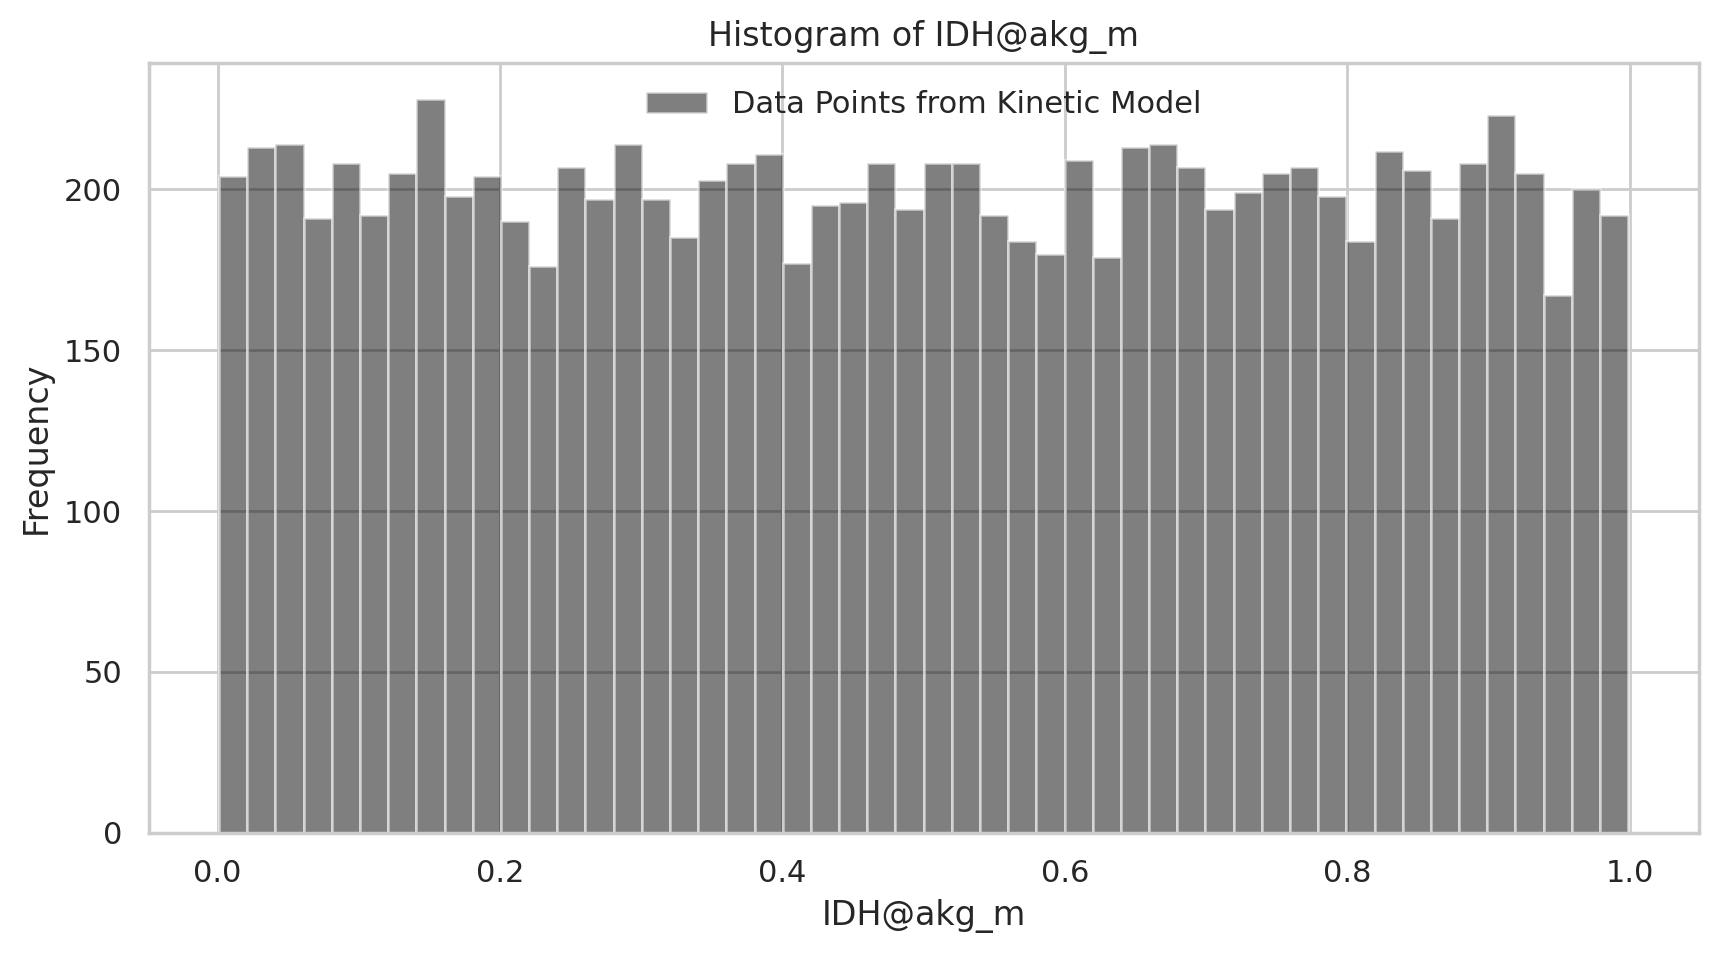

In [88]:
# Plot histogram for a random feature for both real and synthetic data
feature = random.choice(dfcolumns)
plt.figure(figsize=(10, 3))
plt.hist(data[:, dfcolumns.get_loc(feature)], bins=50, color="black", alpha=0.5, label="Data Points from Kinetic Model")
# plt.hist(generated_samples_df[feature], bins=50, color="#00a6d6", alpha=0.5, label="Generated Synthetic Data Points")
plt.xlabel(feature)
plt.ylabel("Frequency")
plt.legend()
plt.title(f"Histogram of {feature}")
plt.show()


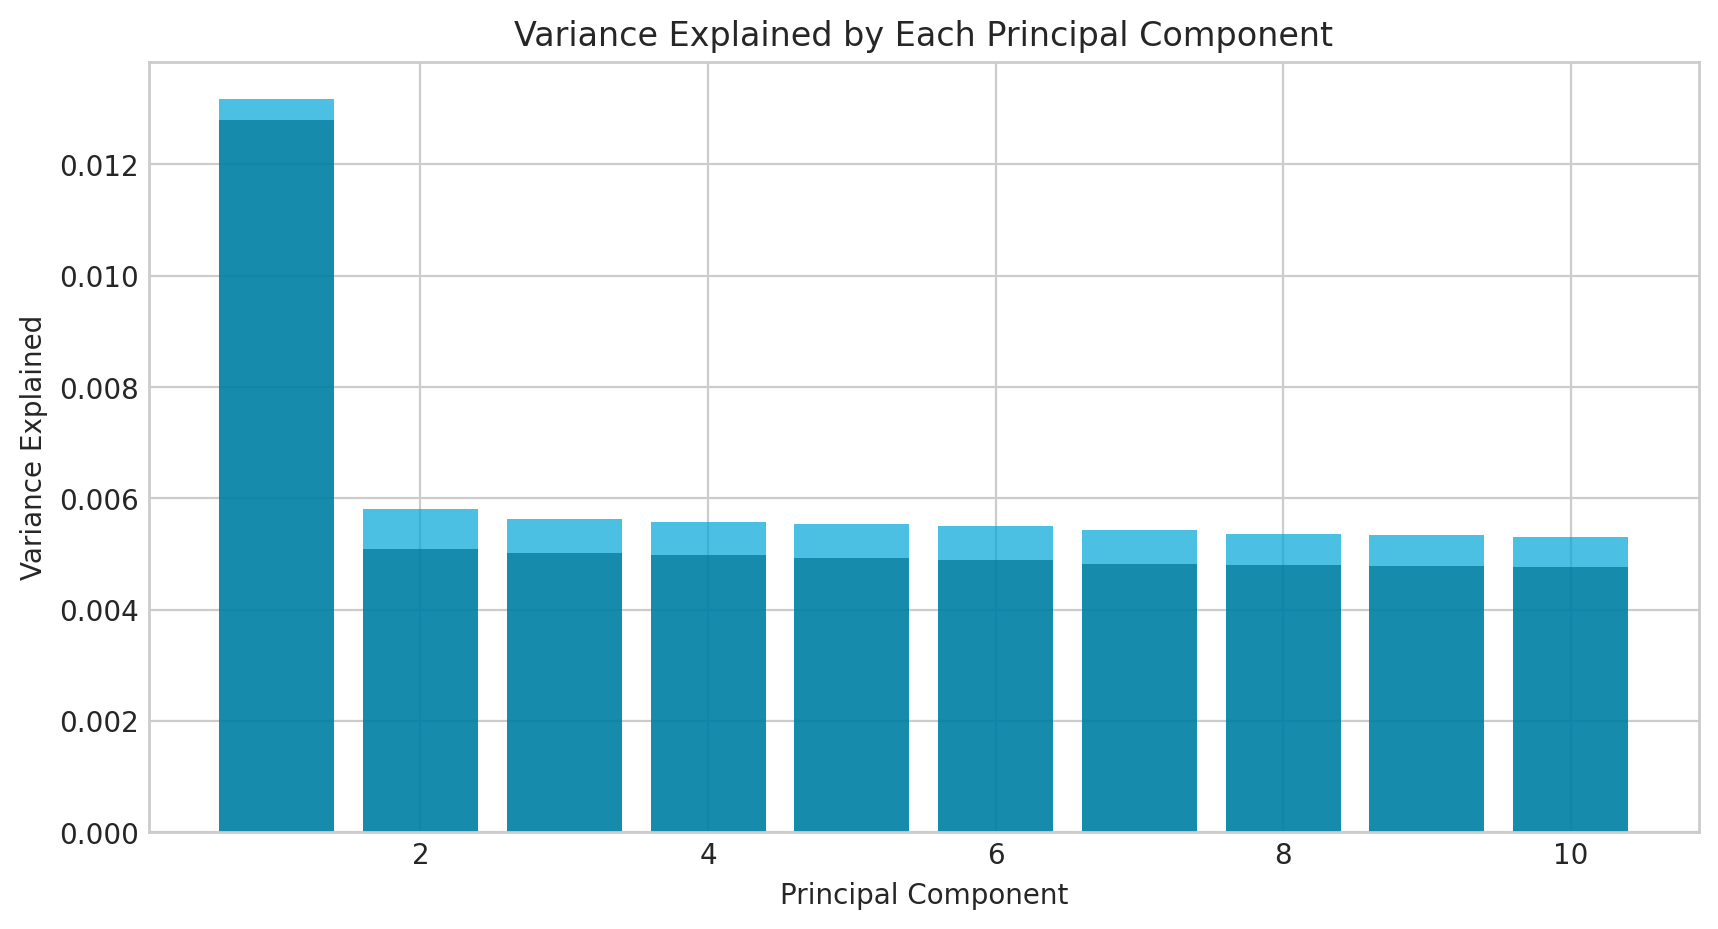

In [71]:
# Calculate the variance explainer by each PCA component and use a bar plot to visualize the results
variance_explained = pca_real.explained_variance_ratio_
variance_explained_synth = pca_synthetic.explained_variance_ratio_
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(1, len(variance_explained) + 1), variance_explained, alpha=0.7, color="black")
ax.bar(range(1, len(variance_explained_synth) + 1), variance_explained_synth, alpha=0.7, color="#00a6d6")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained")
ax.set_title("Variance Explained by Each Principal Component")
plt.grid(True)
plt.show()



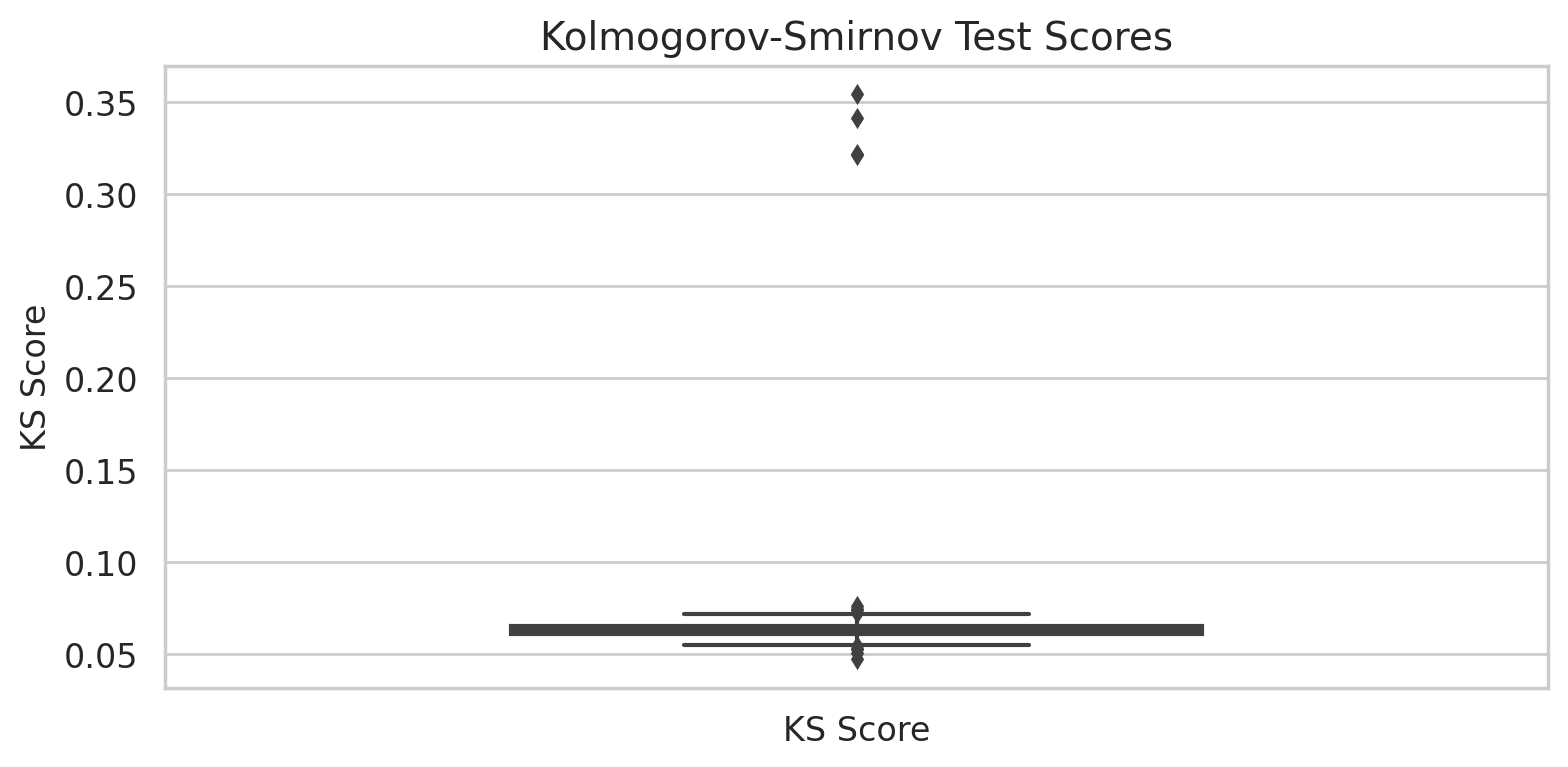

In [83]:
from scipy.stats import ks_2samp, entropy

KS = []
P = []
for c in dfcolumns:
    ks = ks_2samp(df[c], generated_samples_df[c])
    KS.append(ks.statistic)
    P.append(ks.pvalue)
    # print(f'KS score for {c}: {ks.statistic} with p-value {ks.pvalue}')
    # print("-----------------")
    
  
# Create a dataframe to store the results
results = pd.DataFrame({"Feature": dfcolumns, "KS": KS, "P": P})
results = results.sort_values("KS", ascending=False)
results = results.reset_index(drop=True)

import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create a boxplot for KS scores
fig, ax = plt.subplots(figsize=(8, 4))

# Customizing boxplot aesthetics
sns.boxplot(data=results["KS"], orient="v", color="#00a6d6", width=0.5, linewidth=1.5, fliersize=4, ax=ax)

# Customize title and axes labels
ax.set_xticklabels(["KS Score"], fontsize=12)
ax.set_title("Kolmogorov-Smirnov Test Scores", fontsize=14)
ax.set_ylabel("KS Score", fontsize=12)

# Customize tick labels
ax.tick_params(axis="both", labelsize=12)

plt.tight_layout()  # Adjust layout for better spacing

plt.show()


In [80]:
results.sort_values("KS", ascending=False).head(10)

,Feature,KS,P
0,Stability,0.3542,0.000000e+00
1,NDR@nadph_c,0.3414,0.000000e+00
2,NDR@fero_m,0.3216,9.881313e-324
3,ATPM@adp_c,0.3210,9.881313e-324
4,TKL2@f6p_c,0.0759,1.816885e-25
5,GND2@nadph_c,0.0744,1.738781e-24
6,CIT@accoa_m,0.0738,4.237496e-24
7,CITc@oaa_c,0.0723,3.806417e-23
8,NDH@q_m,0.0718,7.833448e-23
9,MLS@glyx_c,0.0701,8.776319e-22


In [89]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [90]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df)
synthetic_data = synthesizer.sample(10000)

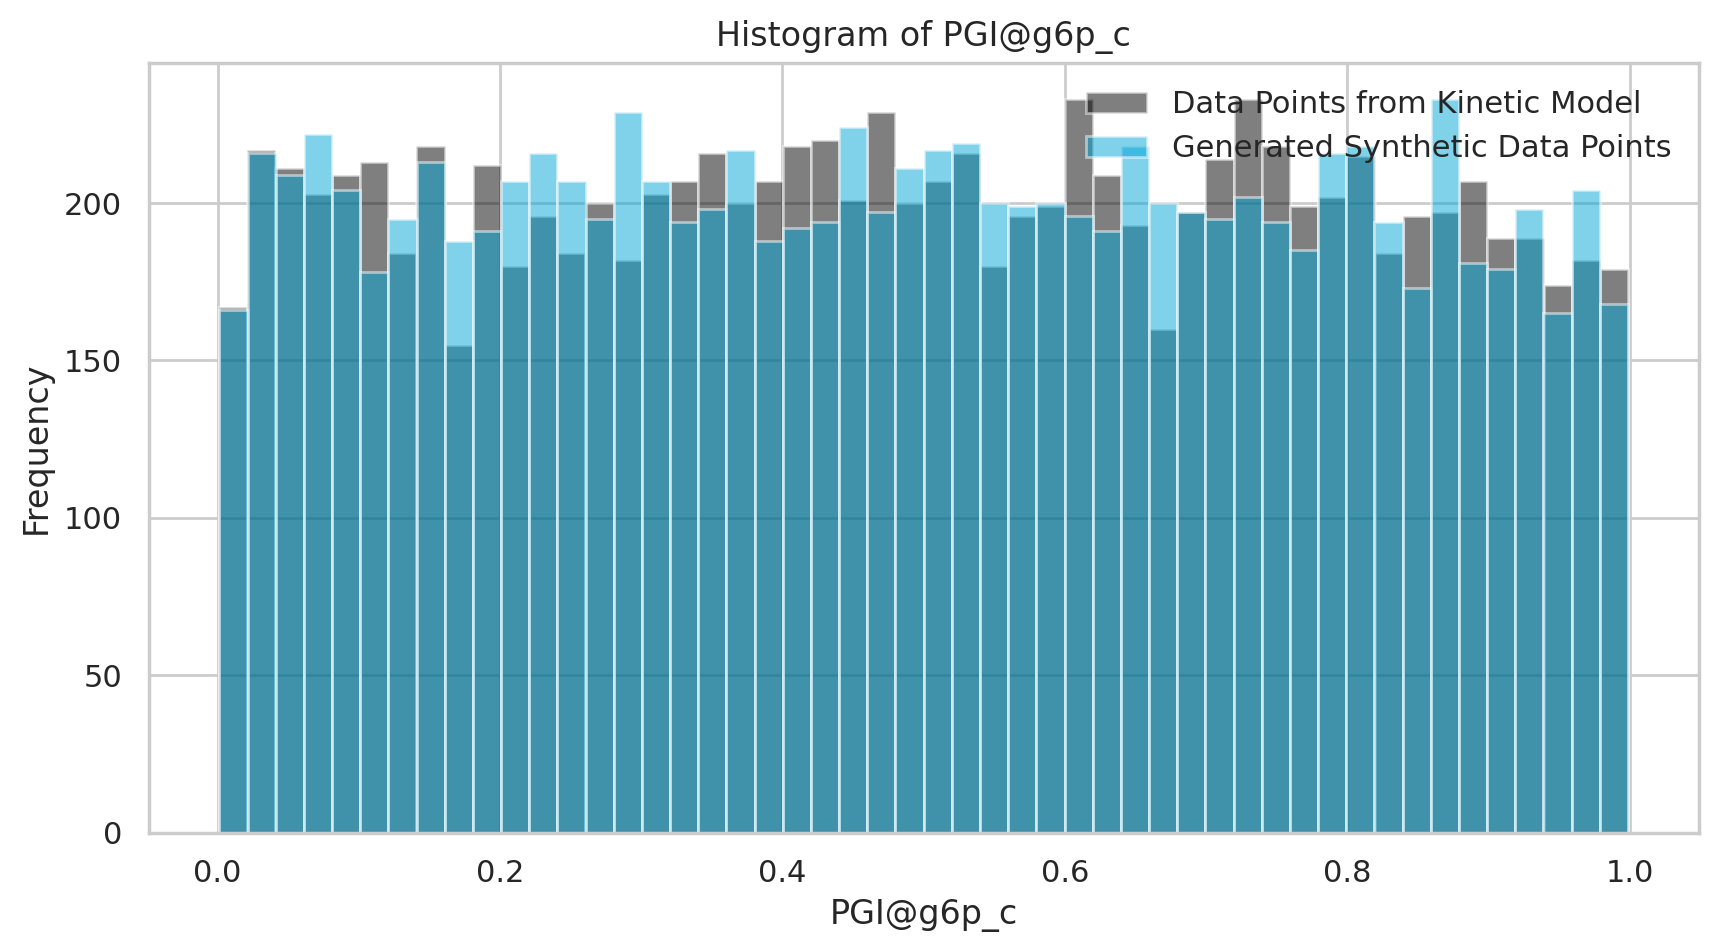

In [95]:
# Plot histogram for a random feature for both real and synthetic data
feature = random.choice(dfcolumns)
plt.figure(figsize=(10, 5))
plt.hist(df[feature], bins=50, color="black", alpha=0.5, label="Data Points from Kinetic Model")
plt.hist(synthetic_data[feature], bins=50, color="#00a6d6", alpha=0.5, label="Generated Synthetic Data Points")
plt.xlabel(feature)
plt.ylabel("Frequency")
plt.legend()
plt.title(f"Histogram of {feature}")
plt.show()